In [ ]:
!pip install sktime
!pip install llvmlite==0.36.0rc1
!pip install --ignore-installed sktime

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

/home/rupeshr/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/home/rupeshr/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
def train_test_split(data, train_ratio):
    len_data = len(data)
    train_size = int(len_data * train_ratio)
    train, test = data[0:train_size], data[train_size:len_data]
    return train, test

def create_forecaster():
    
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
    return forecaster

def lightgbm(*,df, date_col, target_col,param_grid, ratio, freq, future_period):
    df=df[[date_col, target_col]]
    df[date_col]=pd.to_datetime(df[date_col])
    df=df.set_index(date_col)
    df.index = pd.PeriodIndex(df.index, freq=freq) # freq should not be None
    #df.index = pd.DatetimeIndex(df.index, freq=freq)
    
    train, test =train_test_split(df, ratio)
    
    forecaster = create_forecaster()
    cv = ExpandingWindowSplitter(initial_window=int(len(train[target_col]) * 0.7))
    gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=param_grid)
    gscv.fit(train[target_col])
    print(f"best params: {gscv.best_params_}")
    
    # forecasting
    fh=np.arange(len(test)+future_period)+1
    y_pred = gscv.predict(fh=fh)
    prediction = y_pred[:len(test)]
    future = y_pred[len(test):]
    
    
    error= mean_absolute_percentage_error(prediction, test)
    return train, test, prediction, future, error

In [3]:
df=pd.read_csv('/home/rupeshr/Desktop/TSA_Python/dataset/data_new/30-6/daily-total-female-births-CA.csv')
date_col='date'
target_col='births'
param_grid ={"window_length": [5,10]}
ratio=0.80
freq='D' # need to choose present dataset freq
future_period=25
train, test, prediction, future, error=lightgbm(df=df, date_col=date_col, target_col=target_col,param_grid=param_grid, ratio=ratio, freq=freq,future_period=future_period)

best params: {'window_length': 10}


In [ ]:
'''
tunable Hyperparameter

strategey = “direct”, “recursive” or “multioutput”

window_length = default is 10 '''

"freq should be Y , M , Q, D"

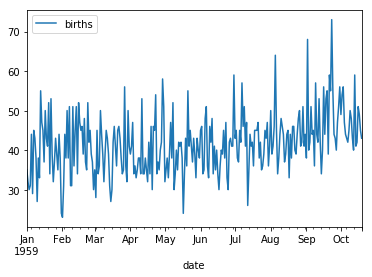

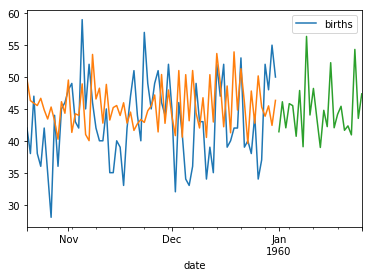

In [4]:
train.plot()
test.plot()
prediction.plot()
future.plot()
plt.show()